In [1]:
import os
from math import pi
from time import time



from autocvd import autocvd
autocvd(num_gpus = 1)


from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, NFW_POTENTIAL, PlummerParams, MN_POTENTIAL, LogarithmicParams, LOGARITHMIC_POTENTIAL, DIFFRAX_BACKEND, DOPRI5
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle
from odisseo.utils import E_tot, Angular_momentum
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, plot_last_snapshot, plot_sky_projection
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
code_length = 10.0 * u.kpc
code_mass = 2.5*1e5 * u.Msun
G = 1
code_time = 1.0 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=G, unit_time=code_time)

In [3]:
# Define the 
config = SimulationConfig(N_particles=1000, 
                          return_snapshots=True, 
                          num_snapshots=500, 
                          num_timesteps=20_000, 
                          external_accelerations=(LOGARITHMIC_POTENTIAL,), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          integrator = DIFFRAX_BACKEND,
                          diffrax_solver=DOPRI5,
                          softening=(8 * u.pc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (3* u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(2.5*1e4 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                          Logarithmic_Params = LogarithmicParams(v0 = (220 * u.km / u.s).to(code_units.code_velocity).value,
                                                                q = 0.9,),
                          G=code_units.G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=True, num_snapshots=500, fixed_timestep=True, num_timesteps=20000, softening=np.float64(0.0008000000000000001), integrator=2, diffrax_solver=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(4,), differentation_mode=1, num_checkpoints=100)
SimulationParams(G=np.float64(0.0011246255378673884), t_end=np.float64(3.0), Plummer_params=PlummerParams(a=np.float64(0.0008000000000000001), Mtot=np.float64(0.10000000000000002)), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(M=4501365375.06545, alpha=1.8, r_c=1.9), Logarithmic_Params=LogarithmicParams(v0=np.float64(22.49966763100529), q=0.9))


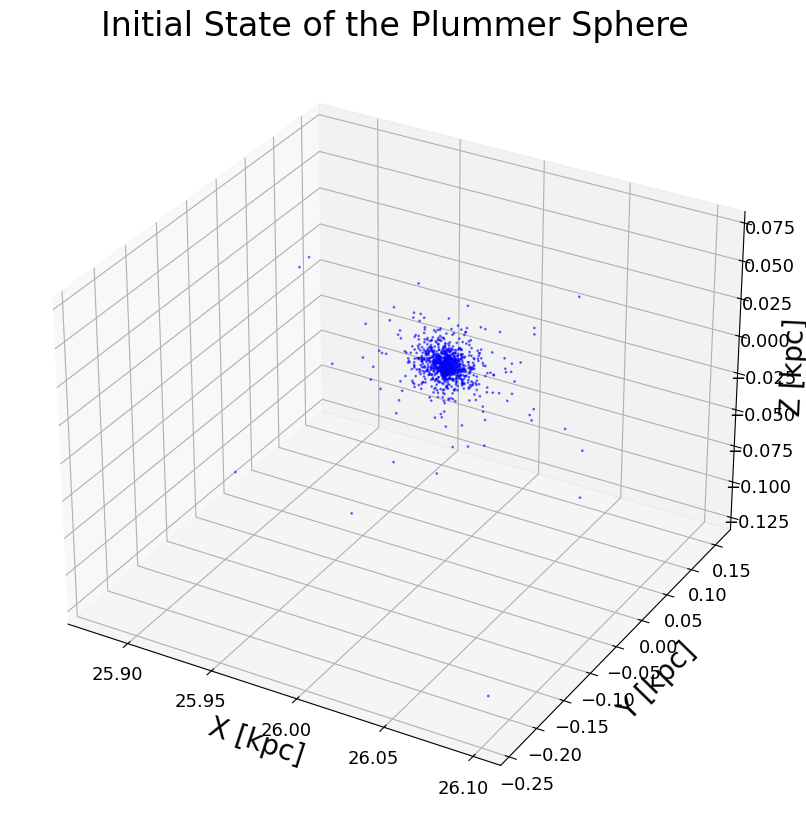

In [4]:
#generate Plummer sphere
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(100), params=params, config=config)
p1 = positions
#generate initial positions of the Plummer sphere
pos = jnp.array([26.0, 0.0, 0.0]) * u.kpc.to(code_units.code_length)
vel = jnp.array([0.0,-141.8, 83.1]) * (u.km/u.s).to(code_units.code_velocity)

#move the Plummer sphere to the initial position
positions = positions + pos
#add the initial velocity to the Plummer sphere
velocities = velocities + vel
#construct the initial state
initial_state = construct_initial_state(position=positions, velocity=velocities)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(initial_state[:, 0, 0]*code_units.code_length.to(u.kpc),
            initial_state[:, 0, 1]*code_units.code_length.to(u.kpc),
            initial_state[:, 0, 2]*code_units.code_length.to(u.kpc),
            s=1, alpha=0.5, color='blue')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
ax.set_title('Initial State of the Plummer Sphere')

#simulate the evolution 
snapshots = time_integration(initial_state, mass, config, params)

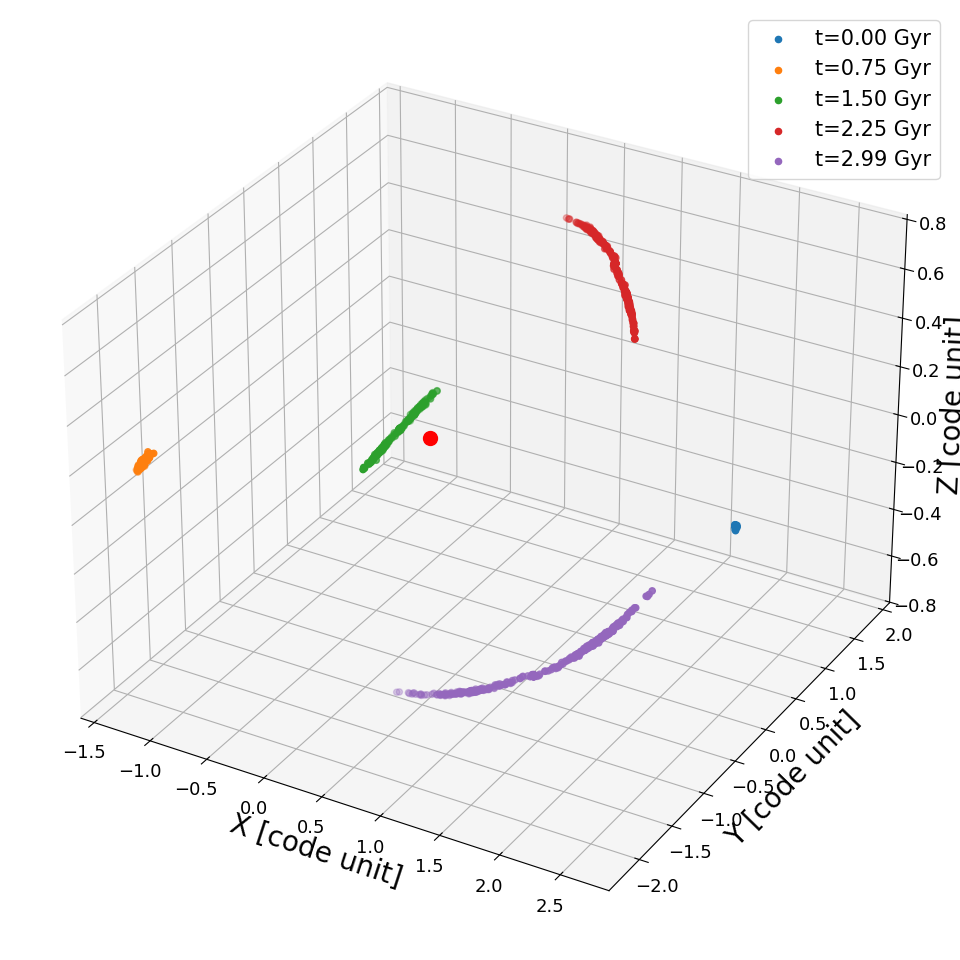

In [5]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0], 
               snapshots.states[i, :, 0, 1], 
               snapshots.states[i, :, 0, 2],label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='red', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')


ax.legend()

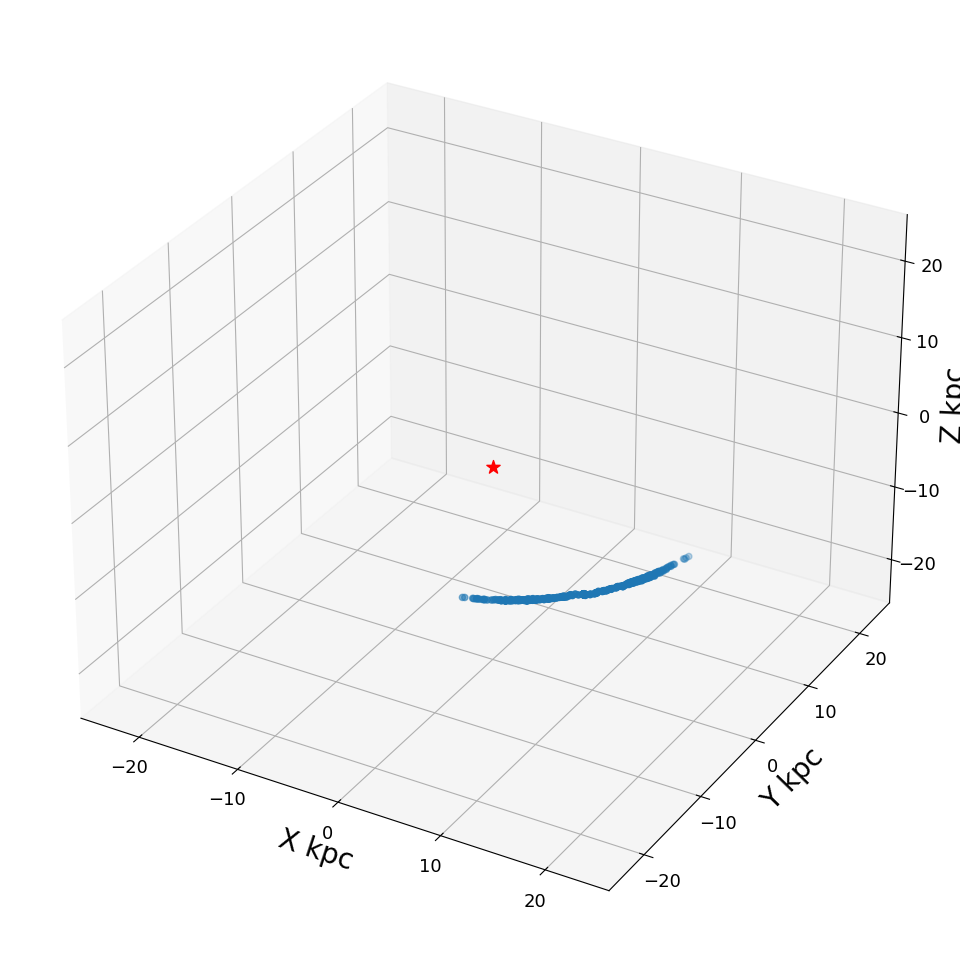

In [11]:
plot_last_snapshot(snapshots, code_units, rp=jnp.linalg.norm(pos), plotting_units_length=u.kpc, filename=None)

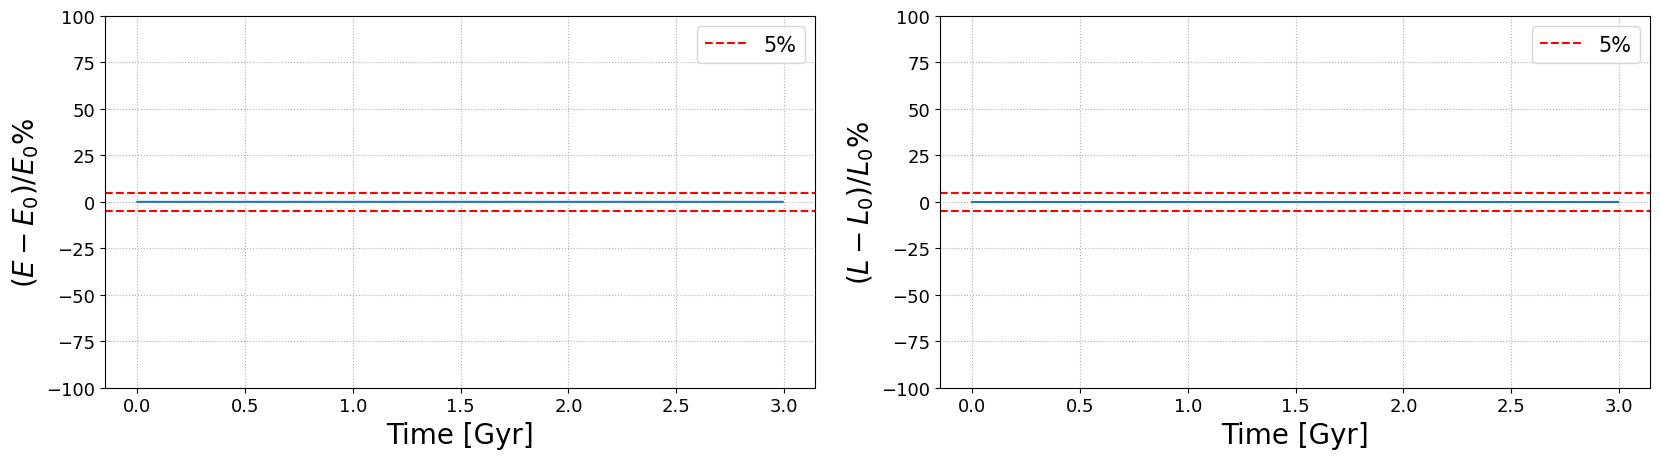

In [10]:
from odisseo.visualization import energy_angular_momentum_plot

energy_angular_momentum_plot(snapshots=snapshots, code_units=code_units, filename=None,)

In [8]:
import jax.numpy as jnp
from jax import jit
from jax.scipy.linalg import svd

# Constants for Galactic to Equatorial conversion (ICRS)
alpha_NGP = jnp.deg2rad(192.85948)
delta_NGP = jnp.deg2rad(27.12825)
l_NCP = jnp.deg2rad(122.93192)
sun_pos = jnp.array([8.0, 0.0, 0.0])  # kpc

@jit
def galactocentric_to_stream_coords(positions):
    # Step 1: Shift to heliocentric frame
    heliocentric = positions - sun_pos  # shape (N, 3)

    # Step 2: Convert to spherical Galactic (r, l, b)
    x, y, z = heliocentric.T
    r = jnp.sqrt(x**2 + y**2 + z**2)
    b = jnp.arcsin(z / r)
    l = jnp.arctan2(y, x)

    # Step 3: Convert Galactic (l, b) -> Equatorial (α, δ)
    sin_b = jnp.sin(b)
    cos_b = jnp.cos(b)
    sin_l_lngp = jnp.sin(l_NCP - l)
    cos_l_lngp = jnp.cos(l_NCP - l)

    delta = jnp.arcsin(jnp.sin(delta_NGP) * sin_b + jnp.cos(delta_NGP) * cos_b * cos_l_lngp)
    alpha = jnp.arctan2(cos_b * sin_l_lngp,
                    jnp.cos(delta_NGP) * sin_b - jnp.sin(delta_NGP) * cos_b * cos_l_lngp) + alpha_NGP
    alpha = alpha % (2 * jnp.pi)

    # Step 4: Convert to unit vectors for fitting great circle
    cos_delta = jnp.cos(delta)
    xyz_eq = jnp.stack([jnp.cos(alpha) * cos_delta,
                        jnp.sin(alpha) * cos_delta,
                        jnp.sin(alpha)], axis=-1)  # shape (N, 3)

    # Step 5: Fit great circle using PCA (SVD)
    _, _, v = svd(xyz_eq - jnp.mean(xyz_eq, axis=0), full_matrices=False)
    R = v  # rotation matrix, rows: [φ1-axis, φ2-axis, normal to great circle]

    # Rotate equatorial vectors into stream-aligned coordinates
    rotated = xyz_eq @ R.T
    xg, yg, zg = rotated.T

    # Step 6: Compute φ1, φ2
    phi1 = jnp.arctan2(yg, xg)
    phi2 = jnp.arcsin(zg)

    return jnp.rad2deg(phi1), jnp.rad2deg(phi2)

phi1, phi2 = galactocentric_to_stream_coords(snapshots.states[-1, :, 0])

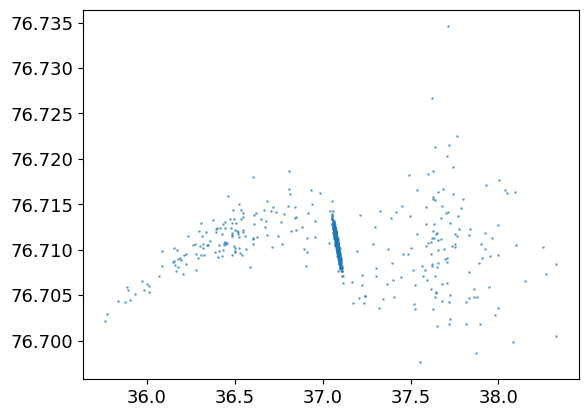

In [9]:
plt.scatter(phi1, phi2, s=1, alpha=0.5)

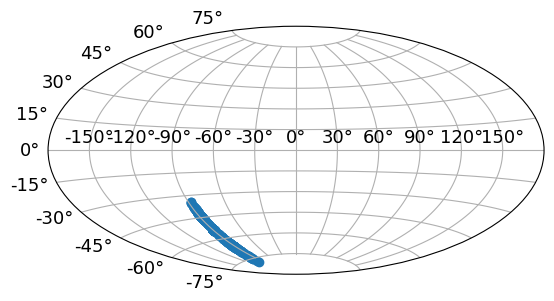

In [26]:
from astropy.coordinates import SkyCoord, CartesianRepresentation, Galactocentric
import astropy.coordinates as coord

last_snapshot = snapshots.states[-1]

x, y, z = last_snapshot[:, 0, 0], last_snapshot[:, 0, 1], last_snapshot[:, 0, 2]
x, y, z = (x * code_units.code_length).to(u.kpc) , (y * code_units.code_length).to(u.kpc), (z * code_units.code_length).to(u.kpc)
vx, vy, vz = last_snapshot[:, 1, 0], last_snapshot[:, 1, 1], last_snapshot[:, 1, 2]
vx, vy, vz = (vx * code_units.code_velocity).to(u.km/u.s), (vy * code_units.code_velocity).to(u.km/u.s), (vz * code_units.code_velocity).to(u.km/u.s)


galactic_coordinate = SkyCoord(x=x, y=y, z=z, v_x=vx, v_y=vy, v_z=vz, frame=coord.Galactocentric)

sky_coordinate = galactic_coordinate.transform_to(coord.ICRS)  # For RA/Dec

plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(sky_coordinate.ra.wrap_at('180d').radian, sky_coordinate.dec.radian)
plt.show()


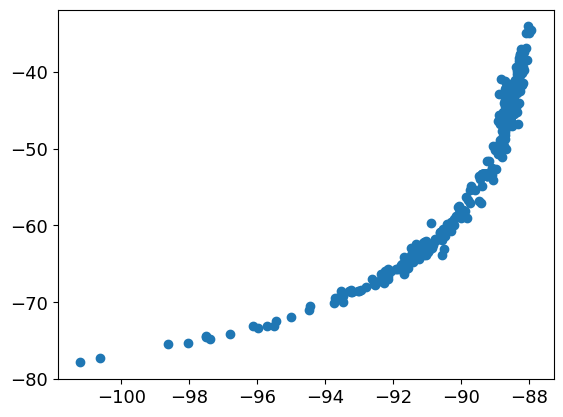

In [14]:
plt.scatter(sky_coordinate.ra.wrap_at('180d'), sky_coordinate.dec)


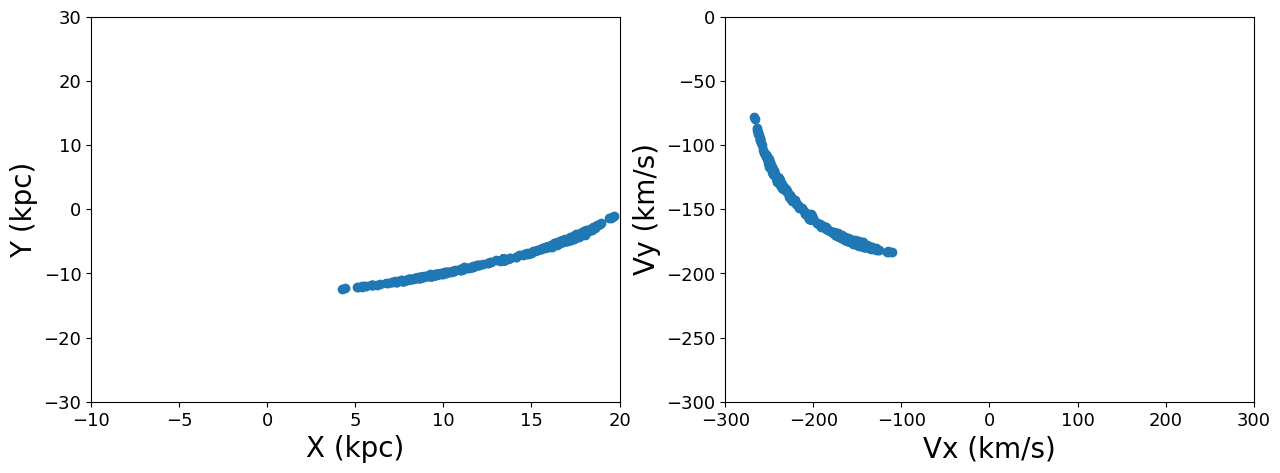

In [15]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.scatter(x, y)
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_xlim(-10, 20)
ax.set_ylim(-30, 30)
ax = fig.add_subplot(122)
ax.scatter(vx, vy)
ax.set_xlabel('Vx (km/s)')
ax.set_ylabel('Vy (km/s)')
ax.set_xlim(-300, 300)
ax.set_ylim(-300,0)
# ax.yaxis_inverted()
plt.show()

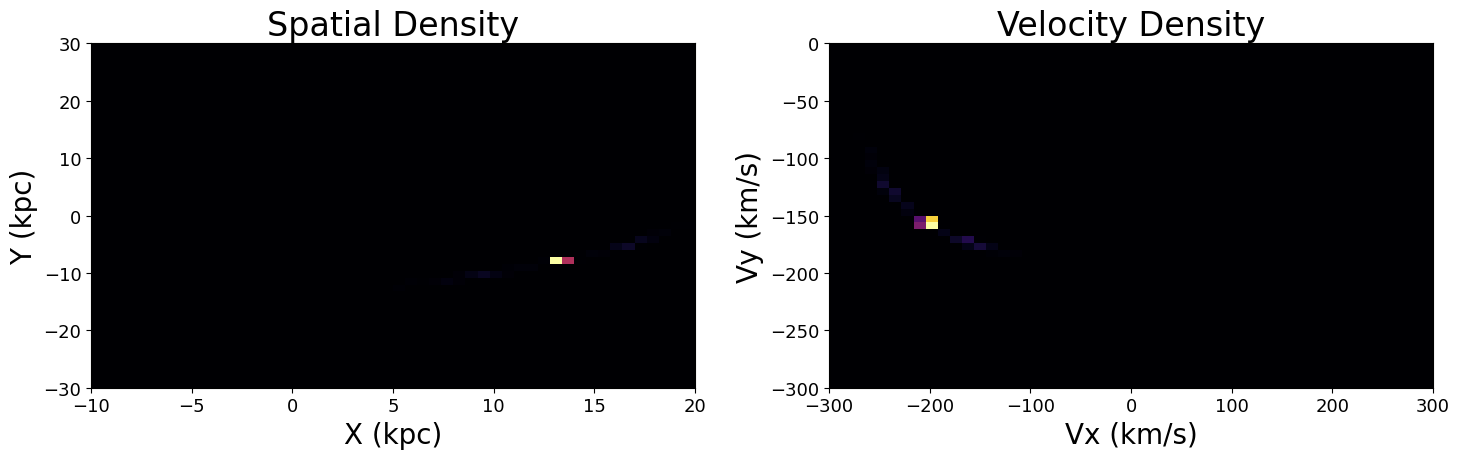

In [16]:
import matplotlib.pyplot as plt
import numpy as np

x, y, z = x.value, y.value, z.value
vx, vy, vz = vx.value, vy.value, vz.value

# Create 2D histogram
H1, xedges, yedges = np.histogram2d(x, y, bins=50, range=[[-10, 20], [-30, 30]])

fig = plt.figure(figsize=(15, 5))

# Density of spatial positions
ax = fig.add_subplot(121)
ax.imshow(H1.T, origin='lower', aspect='auto',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          cmap='inferno')
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_title('Spatial Density')

# Velocity space density
H2, vxedges, vyedges = np.histogram2d(vx, vy, bins=50, range=[[-300, 300], [-300, 0]])
ax = fig.add_subplot(122)
ax.imshow(H2.T, origin='lower', aspect='auto',
          extent=[vxedges[0], vxedges[-1], vyedges[0], vyedges[-1]],
          cmap='inferno')
ax.set_xlabel('Vx (km/s)')
ax.set_ylabel('Vy (km/s)')
ax.set_title('Velocity Density')

plt.tight_layout()
plt.show()


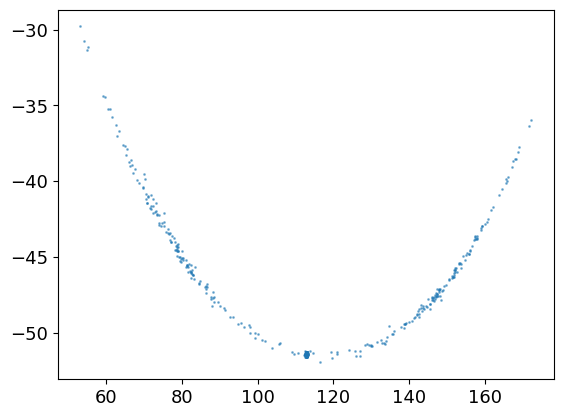

In [17]:
from odisseo.utils import gd1_projection_vmap
X_halo, V_halo = gd1_projection_vmap(snapshots.states[-1, :, 0], snapshots.states[-1, :, 1], code_units)
plt.plot(jnp.rad2deg(X_halo[:, 1]), jnp.rad2deg(X_halo[:, 2]), 'o', markersize=1, alpha=0.5)

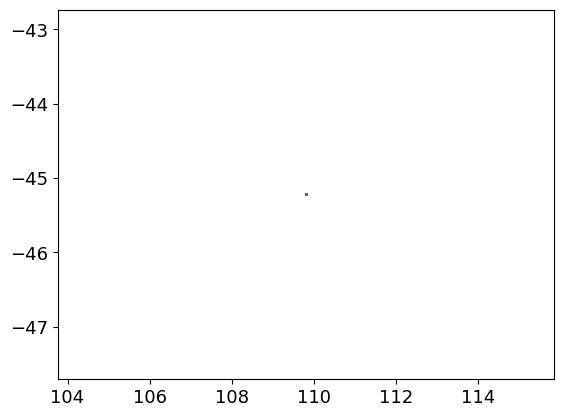

In [17]:
import astropy.coordinates as coord
import gala.coordinates as gc

c = coord.ICRS(ra=sky_coordinate.ra, dec=sky_coordinate.dec, distance=sky_coordinate.distance)
c_gd1 = c.transform_to(gc.GD1Koposov10())
plt.plot(c_gd1.phi1, c_gd1.phi2, 'o', markersize=1, alpha=0.5, label='GD-1 Koposov 2010 (Astropy)')

# Reversed Flow 

In [18]:
# Define the 
params = params._replace(t_end = (-1* u.Gyr).to(code_units.code_time).value)  # Change the end time to 1 Gyr
print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=True, num_snapshots=1000, fixed_timestep=True, num_timesteps=1000, softening=np.float64(0.0008000000000000001), integrator=0, diffrax_solver=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(4,), differentation_mode=1, num_checkpoints=100)
SimulationParams(G=1, t_end=np.float64(-0.03353543704601728), Plummer_params=PlummerParams(a=np.float64(0.0008000000000000001), Mtot=np.float64(0.10000000000000002)), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(M=4501365375.06545, alpha=1.8, r_c=1.9), Logarithmic_Params=LogarithmicParams(v0=np.float64(670.9221531877242), q=0.9))


In [19]:
# Backwards
# final_snapshot = snapshots.states.at[-1, :, 1].set(-snapshots.states[-1, :, 1])  # Reverse velocities for backwards integration
# final_snapshot = final_snapshot[-1, :]
final_snapshot = snapshots.states[-1, :,]  # Use the last snapshot's positions for backwards integration  
snapshots = time_integration(final_snapshot, mass, config, params)

In [20]:
snapshots.times * code_units.code_time.to(u.Gyr)

Array([ 0.   , -0.001, -0.002, -0.004, -0.005, -0.006, -0.007, -0.008,
       -0.009, -0.01 , -0.011, -0.012, -0.013, -0.014, -0.015, -0.016,
       -0.017, -0.018, -0.019, -0.02 , -0.021, -0.022, -0.023, -0.024,
       -0.025, -0.026, -0.027, -0.028, -0.029, -0.03 , -0.031, -0.032,
       -0.033, -0.034, -0.035, -0.036, -0.037, -0.038, -0.039, -0.04 ,
       -0.041, -0.042, -0.043, -0.044, -0.045, -0.046, -0.047, -0.048,
       -0.049, -0.05 , -0.051, -0.052, -0.053, -0.054, -0.055, -0.056,
       -0.057, -0.058, -0.059, -0.06 , -0.061, -0.062, -0.063, -0.064,
       -0.065, -0.066, -0.067, -0.068, -0.069, -0.07 , -0.071, -0.072,
       -0.073, -0.074, -0.075, -0.076, -0.077, -0.078, -0.079, -0.08 ,
       -0.081, -0.082, -0.083, -0.084, -0.085, -0.086, -0.087, -0.088,
       -0.089, -0.09 , -0.091, -0.092, -0.093, -0.094, -0.095, -0.096,
       -0.097, -0.098, -0.099, -0.1  , -0.101, -0.102, -0.103, -0.104,
       -0.105, -0.106, -0.107, -0.108, -0.109, -0.11 , -0.111, -0.112,
      

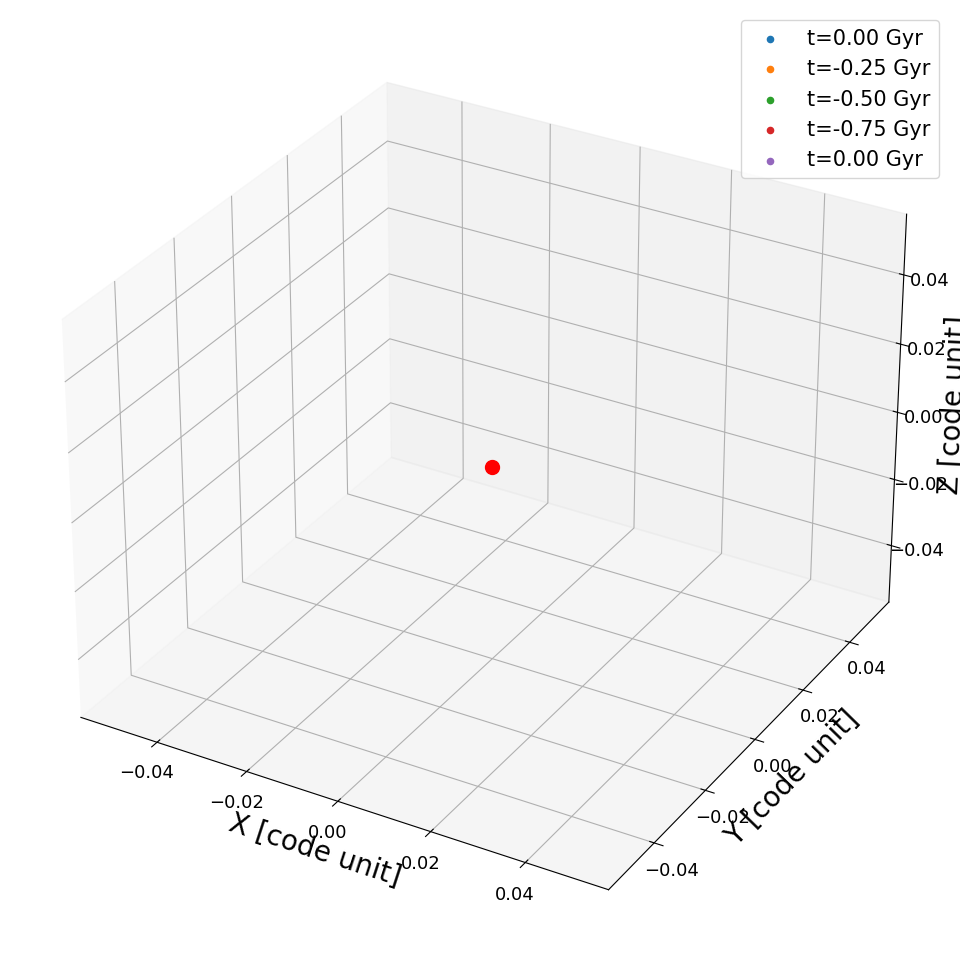

In [21]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, endpoint=True, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0], 
               snapshots.states[i, :, 0, 1], 
               snapshots.states[i, :, 0, 2],label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='red', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')


ax.legend()

Text(0.5, 0.92, 'Final State of the Plummer Sphere (Backwards Integration)')

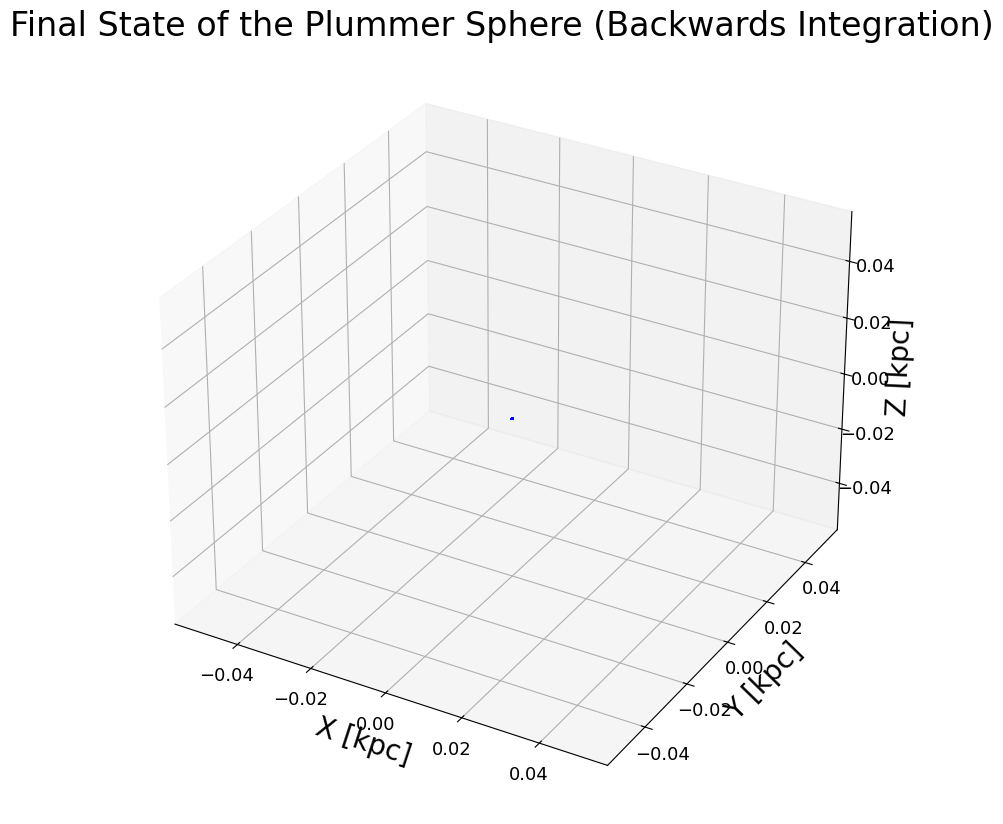

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots.states[-1, :, 0, 0]*code_units.code_length.to(u.kpc),
            snapshots.states[-1, :, 0, 1]*code_units.code_length.to(u.kpc),
            snapshots.states[-1, :, 0, 2]*code_units.code_length.to(u.kpc),
            s=1, alpha=0.5, color='blue')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
ax.set_title('Final State of the Plummer Sphere (Backwards Integration)')

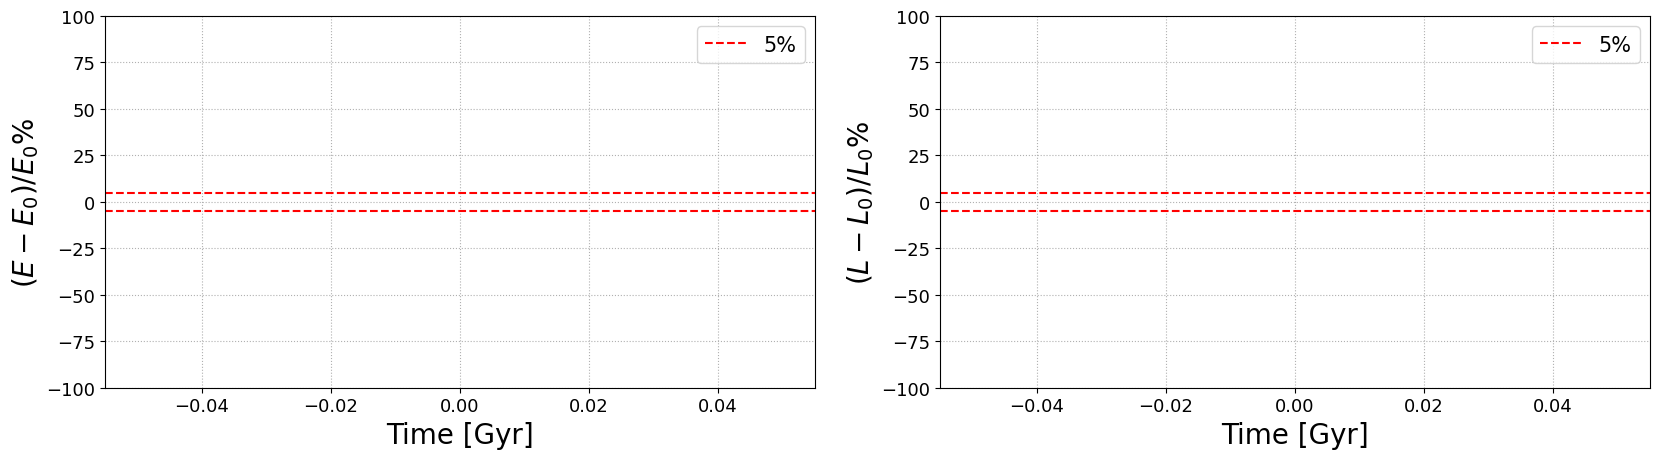

In [23]:
from odisseo.visualization import energy_angular_momentum_plot

energy_angular_momentum_plot(snapshots=snapshots, code_units=code_units, filename=None,)

In [24]:
snapshots.current_checkpoint

Array(999, dtype=int64, weak_type=True)

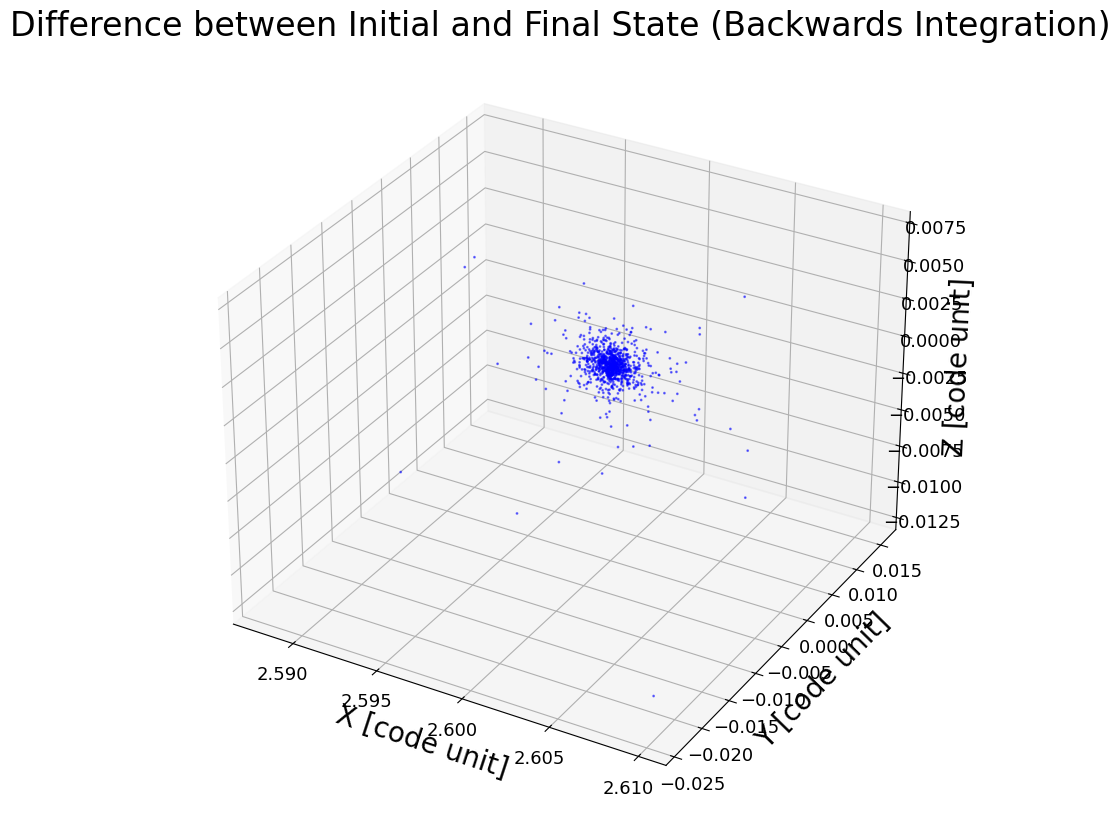

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(initial_state[:, 0, 0] - snapshots.states[-1, :, 0, 0],
            initial_state[:, 0, 1] - snapshots.states[-1, :, 0, 1],
            initial_state[:, 0, 2] - snapshots.states[-1, :, 0, 2],
            s=1, alpha=0.5, color='blue')
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.set_title('Difference between Initial and Final State (Backwards Integration)')
plt.show()